In [1]:
import random
import numpy as np
from numpy.random import normal as noise
import linear_model as lm
from linear_model import BayesianLinearModel
from scipy.stats import multivariate_normal as normal
from scipy.stats import norm
import matplotlib.pyplot as plt

In [2]:
N = 5000

# Ejercicio 1

In [ ]:
def simular1(N=5000, do_x=None):
    # Si hay intervencion, usar x = do_x, sino generarlo del modelo original
    Z = np.random.uniform(-3,3, size=N)
    if do_x is None:
        X = 1 + 3*Z + 2*Z**3 + np.random.normal(size=N,scale=6)
    else:
        X = np.full(N, do_x)
    Y = -1 - 2*X + 6*Z**2 + np.random.normal(size=N,scale=1)
    return Z, X, Y


In [30]:
# Generamos los datos sin intervenciones
N = 5000
Z1s, X1s, Y1s = simular1(N)

Ploteamos

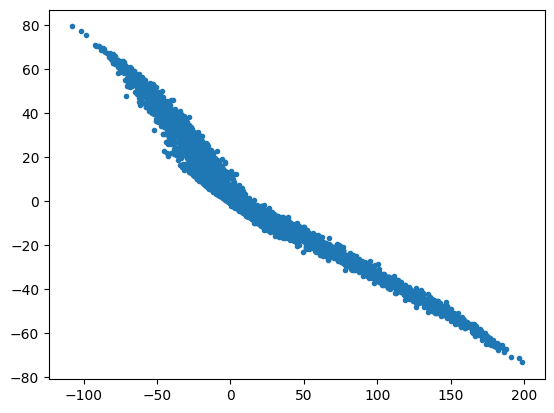

In [29]:
plt.plot(Y1s, X1s, '.');

Si no conocemos el prior de Z, podemos ver su distribucioon de datos

In [6]:
# Backdoor
# 
# P(y|do(x)) = \sum_z P(y,z|do(x))
#            = \sum_z P(y|x,z).P(z)

## a) sin intervencion

$$
y - w_0 + w_1x + w_2z
$$
$$
=
$$
$$
P(y|x,z,w, Datos) = \int_w N(y|w_0 + w_1 x + w_2 z, \beta^{-1}) P(w|Datos)
$$

In [ ]:

PHI1a = np.concatenate([
    np.ones(N).reshape(N, 1),
    X1s.reshape(N, 1),
    (Z1s**2).reshape(N, 1)],axis=1)

# Ajustamos el modelo
blm1a= BayesianLinearModel(basis=lambda x: x)
blm1a.update(PHI1a, Y1s.reshape(N,1))

# Obtenemos las estimaciones
mean1a = blm1a.location
cov1a = blm1a.dispersion
ev1a = blm1a.evidence()

In [34]:
print('mean :', mean1a, '\ncov :', cov1a, '\nevidence: ', ev1a)

mean : [[-0.98414319]
 [-2.00015562]
 [ 5.99535522]] 
cov : [[ 4.53058539e-04 -3.21232218e-07 -8.29060139e-05]
 [-3.21232218e-07  2.87919647e-07  3.06713429e-08]
 [-8.29060139e-05  3.06713429e-08  2.71806730e-05]] 
evidence:  -7099.427517853779


La media de las estimaciones de los pesos:  
+ La ordenada al origen  
+ Peso de x = -2 (Correcto, mirar ecuacion original).  
+ El tercer peso es el peso de z**2 , correcto tambien.

Backdoor:  
$ P(y|do(x)) = \sum_z P(y|x,z) P(z) $  
$ P(z) = U[z|-3,3] = 1/6$

In [ ]:
def p_Y_do_x(y, x, blm, dz=0.01):
    res = 0
    pz = 1/6
    for z in np.arange(-3, 3+dz, dz):
        _, _, py_xz = blm.predict(
            X=np.array([1, x, z**2]).reshape((1,3)),
            y=np.array([y]))
        res += py_xz * pz * dz
        # el producto de las probabilidades es la altura y dz es la base de los rectangulos de la suma de reimann
    return res

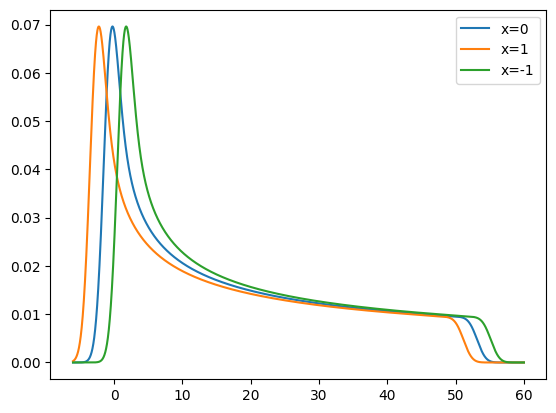

In [36]:
y_grilla = np.arange(-6, 60, 0.01)

plt.plot(y_grilla, p_Y_do_x(y=y_grilla,x=0, blm=blm1a), label= "x=0")
plt.plot(y_grilla, p_Y_do_x(y=y_grilla,x=1, blm=blm1a), label= "x=1")
plt.plot(y_grilla, p_Y_do_x(y=y_grilla,x=-1, blm=blm1a), label= "x=-1")
plt.legend();

In [ ]:
sum(p_Y_do_x(y=y_grilla,x=1, blm=blm1a)*0.01) # deberia dar 1

array([1.001587])

In [13]:
def media_Y_do_x(py_do_x , y_grilla):
    # E[y|do(x)] = \int_y y P(y|do(x)) dy
    dy = y_grilla[1] - y_grilla[0]
    return sum(py_do_x[:,0] * y_grilla * dy)

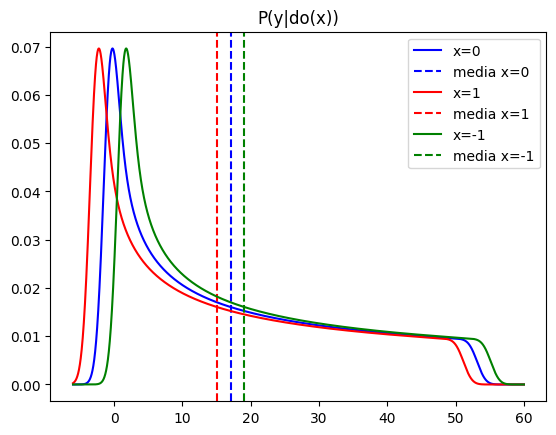

In [41]:
y_grilla = np.arange(-6, 60, 0.01)

for x, color in zip([0, 1, -1], ['blue', 'red', 'green']):
    plt.plot(y_grilla, p_Y_do_x(y=y_grilla, x=x, blm=blm1a), label=f"x={x}", color=color)
    plt.axvline(media_Y_do_x(p_Y_do_x(y=y_grilla, x=x, blm=blm1a), y_grilla), label=f"media x={x}", linestyle='--', color=color)
    plt.legend()

plt.title("P(y|do(x))");

In [15]:
# Creo una grilla de Y
y_grilla = np.arange(-20, 80, 0.02)
x_grilla = np.arange(-6, 6+2, 2)

#E(y|do(x=0))
medias1_estimadas_con_backdoor = []
medias1_estimadas_con_experimento = []
for x in x_grilla:
    medias1_estimadas_con_backdoor.append(
        media_Y_do_x(p_Y_do_x(y=y_grilla, x=x, blm=blm1a), y_grilla)
    )
    _, _, Yx = simular1(N=5000, do_x=x)
    medias1_estimadas_con_experimento.append(
        np.mean(Yx)
    )

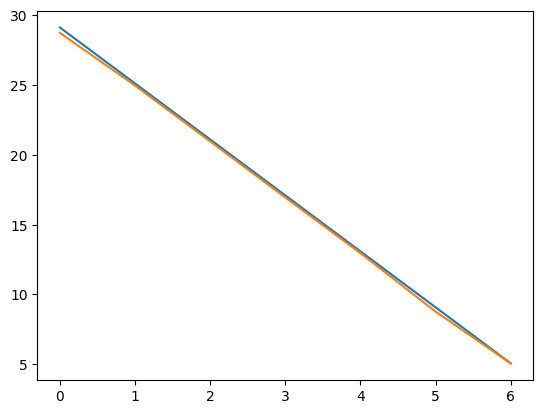

In [16]:
plt.plot(medias1_estimadas_con_backdoor)
plt.plot(medias1_estimadas_con_experimento);

# Realidad Causal 2

$Q = z$

In [42]:
def simular2(N=5000, do_x=None):
    U = np.random.uniform(-3,3, size=N)
    Z = 3*U**3 + np.random.uniform(-1.5,1.5, size=N)
    if do_x is None:
        X = 3*Z + np.random.normal(size=N, scale=3)
    else:
        X = np.full(N, do_x)
    Y = -1 - 2*X + 6*U**2 + np.random.normal(size=N, scale=1)
    return U, Z, X, Y

In [43]:
# Generamos los datos sin intervenciones
U, Z, X, Y = simular2()

In [48]:
PHI2 = np.concatenate([
    np.ones(N).reshape(N, 1),
    X.reshape(N, 1),
    (U**2).reshape(N, 1)
    ],axis=1)

In [49]:
blm2 = BayesianLinearModel(basis=lambda x: x)
blm2.update(PHI2, Y.reshape(N,1))

In [50]:
mean2 = blm2.location
cov2 = blm2.dispersion
ev2 = blm2.evidence()

print('mean :', mean2, '\ncov :', cov2, '\nevidence: ', ev2)

mean : [[-0.99936259]
 [-2.00010339]
 [ 5.99419818]] 
cov : [[ 4.50484748e-04  5.30114333e-09 -8.37779233e-05]
 [ 5.30114333e-09  2.39167055e-08  3.77581273e-09]
 [-8.37779233e-05  3.77581273e-09  2.80219174e-05]] 
evidence:  -7176.7539177664485


# Realidad Causal 4

In [17]:
def simular4(N, do_x=None):
    # Si hay intervencion, usar x = do_x, sino generarlo del modelo original
    Z = np.random.normal(size=N, scale=1)
    if do_x is None:
        X = Z**2 + np.random.normal(size=N, scale=1)
    else:
        X = np.full(N, do_x)
    M = 2*Z**2 + 10*X + np.random.normal(size=N, scale=1)
    Y = -1 + 2*M**2 + np.random.normal(size=N, scale=1)
    return Z, X, M, Y

N = 10000
Z4s, X4s, M4s, Y4s = simular4(N)

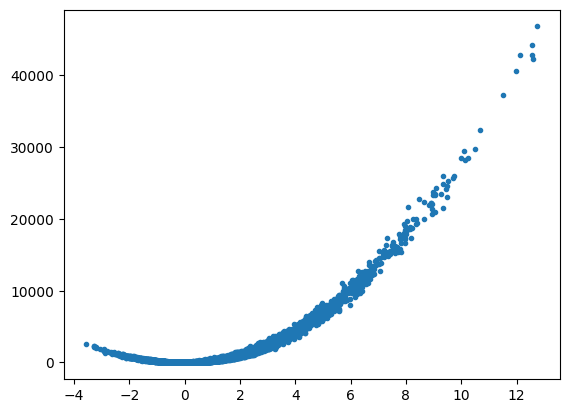

In [18]:
plt.plot(X4s, Y4s, '.');

$$
y = w_o + w_1 x² + w_2 xz² + w_3z⁴ +  \epsilon
$$

In [19]:
PHI4 = np.concatenate([
    np.ones(N).reshape(N, 1),
    (X4s**2).reshape(N, 1),
    (X4s*Z4s**2).reshape(N, 1),
    (Z4s**4).reshape(N, 1)],
    axis=1)

In [20]:
blm4= BayesianLinearModel(basis=lambda x: x)
blm4.update(PHI4, Y4s.reshape(N,1) )
print("Evidencia = ", blm4.evidence())

Evidencia =  -59542.65373314885


In [21]:
m4 = blm4.location
S4 = blm4.dispersion

In [22]:
m4

array([[  1.5182179 ],
       [199.34119648],
       [ 77.82928029],
       [ 10.44102214]])

Ahora estimemos el efecto causal

In [ ]:
def p4_Y_doX(y, x, blm=blm4, dz=0.01):
    z_grilla = np.arange(-3, 3+dz, dz)
    pz = norm(loc=np.mean(Z4s), scale=np.std(Z4s)).pdf(z_grilla)
    res = 0
    for i, z in enumerate(z_grilla):
        _, _, py_xz = blm.predict(
            X=np.array([1, x**2, x*z**2, z**4]).reshape((1,4)),
            y=np.array([y]), variance=True)
        res += (pz[i]*py_xz)*dz
    return res

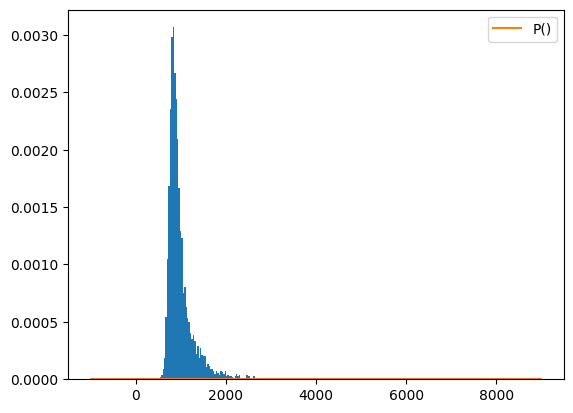

In [24]:
y_grilla = (-1000, 9000, 1)

plt.hist(simular4(N=5000, do_x=2)[3], bins=100, density=True)
plt.plot(y_grilla, p4_Y_doX(y=y_grilla,x=2), label="P()")
plt.legend();